# Seismic deconvolution: one problem, many (possible) solutions

**Author: M. Ravasi, KAUST**

Welcome to our first tutorial at Transform2022!

The aim of this tutorial is to 

- Discuss a well-known and well studied problem in signal processing (and geophysics), namely seismic deconvolution;

- Showcase a number of alternative solutions discussing their pros and cons
- As a by-product of the above, show how different libraries in the Python ecosystem (e.g., NumPy/SciPy, PyLops, PyProximal, PyTorch) can be used to solve such a problem

## Useful links

- Tutorial Github repository: https://github.com/PyLops/pylops_transform2022
        
- PyLops Github repository: https://github.com/PyLops/pylops

- PyLops reference documentation: https://pylops.readthedocs.io/en/latest/

## Theory in a nutshell

In this tutorial we will try to keep the theory to a minimum and quickly expose you to practical examples. However, we want to make sure that some of the basic underlying concepts are clear to everyone and define a common mathematical notation.

<img src="figs/Convmodel.png" width="600">

...


We will consider the following possible ways of solving this problem:

-
-
-
-
-


Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops==1.18.0 pyproximal

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import pyproximal

from IPython.core.display import HTML
from scipy.sparse.linalg import lsqr
from pylops.utils.wavelets import ricker
from pylops.utils import dottest

In [3]:
# Center figures
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Data creation

Dot test passed, v^H(Opu)=4.1307020727409425 - u^H(Op^Hv)=4.130702072740949


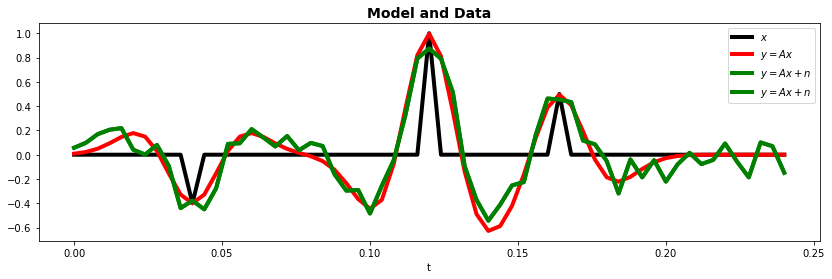

In [4]:
# Model
nt = 61
dt = 0.004
t = np.arange(nt) * dt
x = np.zeros(nt)
x[10] = -0.4
x[int(nt / 2)] = 1
x[nt - 20] = 0.5

# Operator
h, th, hcenter = pylops.utils.wavelets.ricker(t[:101], f0=20)
Cop = pylops.signalprocessing.Convolve1D(nt, h=h, offset=hcenter, dtype="float32")
dottest(Cop, verb=True)

# Data
y = Cop * x
yn = y + np.random.normal(0, 0.1, y.shape)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=4, label=r"$x$")
ax.plot(t, y, "r", lw=4, label=r"$y=Ax$")
ax.plot(t, yn, "g", lw=4, label=r"$y=Ax + n$")
ax.plot(t, yn, "g", lw=4, label=r"$y=Ax + n$")
ax.set_xlabel("t")
ax.set_title("Model and Data", fontsize=14, fontweight="bold")
ax.legend();

## Frequency domain decon

## Time domain decon

Overall theory

### Least-squares solution

Theory

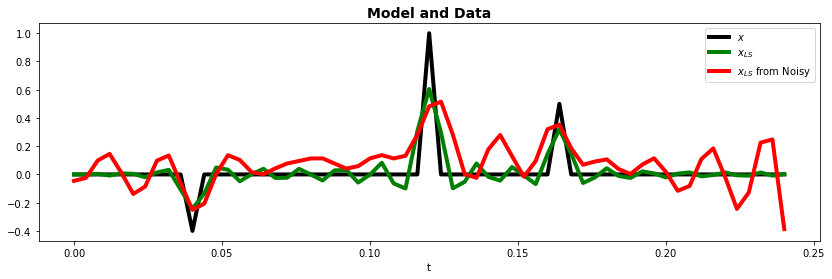

In [26]:
xls = Cop / y
xnls = Cop / yn

xls = lsqr(Cop, y, damp=1e-10, iter_lim=1000, show=0)[0]
#xnls = lsqr(Cop, yn, damp=1e-1, iter_lim=1000, show=0)[0]
xnls = pylops.optimization.leastsquares.RegularizedInversion(
    Cop, [], yn, returninfo=False, **dict(damp=1e-1, atol=1e-3, iter_lim=100, show=0))

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=4, label=r"$x$")
ax.plot(t, xls, "g", lw=4, label=r"$x_{LS}$")
ax.plot(t, xnls, "r", lw=4, label=r"$x_{LS}$ from Noisy")
ax.set_xlabel("t")
ax.set_title("L2 Deconvolution", fontsize=14, fontweight="bold")
ax.legend();

### Sparse solution

Theory of L1 regularized inversion... we can have 3 examples:
    
- Greedy algs (OMP)
- Iterative-thresh algs (ISTA, FISTA)
- Connect them to overall theory of Proximal algs (Proximal grad)

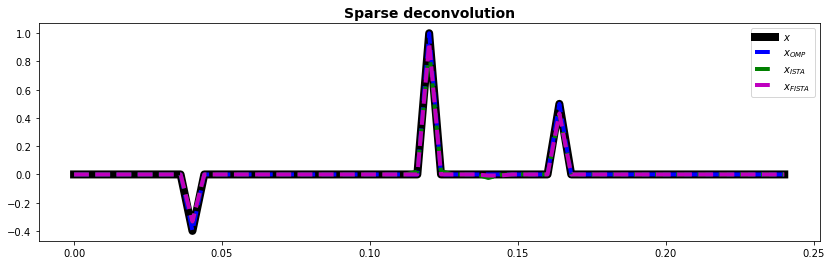

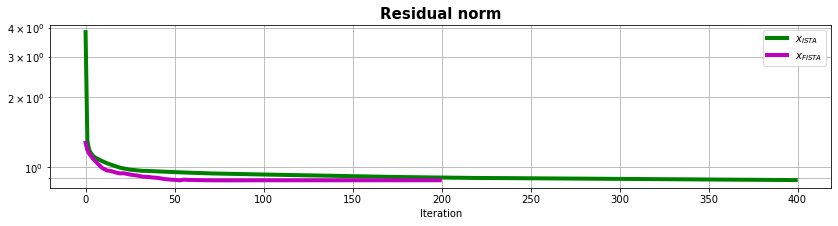

In [48]:
# noise-free
xomp, _, resomp = pylops.optimization.sparsity.OMP(
    Cop, y, niter_outer=10, sigma=1e-8)

xista, _, resista = pylops.optimization.sparsity.ISTA(
    Cop, y, niter=400, eps=5e-1, tol=1e-8, returninfo=True)

xfista, _, resfista = pylops.optimization.sparsity.FISTA(
    Cop, y, niter=200, eps=5e-1, tol=1e-8, returninfo=True)


fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xomp, "--b", lw=4, label=r"$x_{OMP}$")
ax.plot(t, xista, "--g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Sparse deconvolution", fontsize=14, fontweight="bold")
ax.legend();

fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.semilogy(resista, "g", lw=4, label=r"$x_{ISTA}$")
ax.semilogy(resfista, "m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Residual norm", size=15, fontweight="bold")
ax.set_xlabel("Iteration")
ax.legend()
ax.grid(True, which="both")

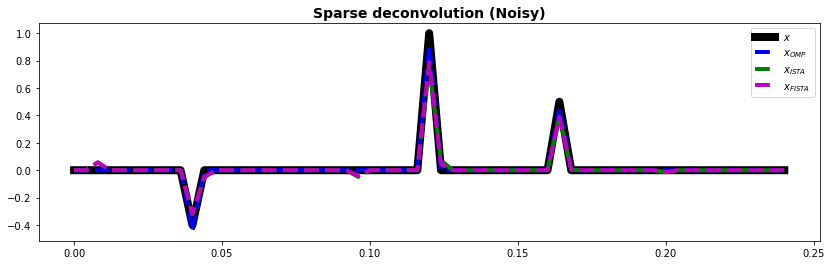

In [49]:
# noisy
xnomp, _, resomp = pylops.optimization.sparsity.OMP(
    Cop, yn, niter_outer=10, sigma=1e0, show=0)

xnista, _, resista = pylops.optimization.sparsity.ISTA(
    Cop, yn, niter=400, eps=5e-1, tol=1e-8, returninfo=True)

xnfista, _, resfista = pylops.optimization.sparsity.FISTA(
    Cop, yn, niter=200, eps=5e-1, tol=1e-8, returninfo=True)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xnomp, "--b", lw=4, label=r"$x_{OMP}$")
ax.plot(t, xnista, "--g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xnfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Sparse deconvolution (Noisy)", fontsize=14, fontweight="bold")
ax.legend();

In [52]:
# proximal
l1 = pyproximal.proximal.L1()
l2 = pyproximal.proximal.L2(Op=Cop, b=y)
L = np.abs((Cop.H * Cop).eigs(1)[0])
tau = 0.95/L
eps = 1e-1
niter = 1000

xista_err, xfista_err = [], []
xista = pyproximal.optimization.primal.ProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), 
                epsg=eps, niter=niter)
                #callback=lambda xest: callback(xest, x, xista_err))
xfista = pyproximal.optimization.primal.AcceleratedProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), acceleration='fista',
                epsg=eps, niter=niter)
                #callback=lambda xest: callback(xest, x, xfista_err))

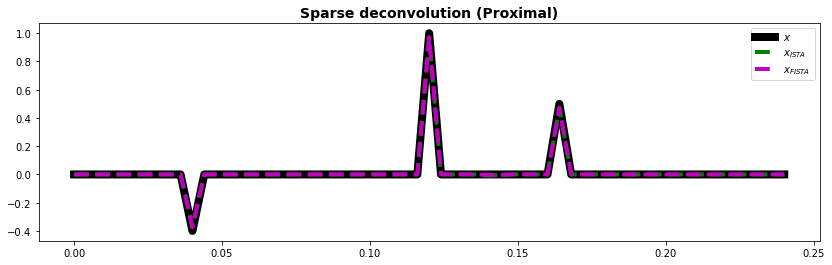

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xista, "--g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Sparse deconvolution (Proximal)", fontsize=14, fontweight="bold")
ax.legend();

## Autograd-style

## Data-driven

## Conclusions